# Objetivos

1. Probar 2 arquitecturas de predicción usando redes neuronales

    Realizar una búsqueda de hiperparámetros para cada una de las arquitecturas y explicar los efectos sobre la gráfica de pérdida cuando se modifica alguno de los hiperparámetros.

2. Hacer feature engineering y ver cual es el efecto sobre el modelo
    


Se utilizará este dataset de datos dfinancieros de empresas proveniente del 'Taiwon Economic Journal' entre los años 1999 y 2009: https://www.kaggle.com/code/marto24/bankruptcy-detection

Se trata de un conjunto de datos con 6910 registros, 95 variables independientes y la variable objetivo 'Bankrupcy?' que indica si la empresa está en bancarrota (1) o no (0).

# Importación de librerías

In [45]:
# IMPORTING LIBRARIES

# General Libraries
import os
import random
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import Counter
import warnings
from google.colab import files
warnings.filterwarnings(action="ignore")

# Preprocessing Libraries
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from imblearn.pipeline import Pipeline, make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning Libraries
import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score, precision_score
from mlxtend.classifier import StackingCVClassifier
from catboost import CatBoostClassifier

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# Defining the working directory


input_path = ''

# Funciones


In [4]:
def plot_history_train(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Importación de datos

In [5]:
# Cargar el archivo
uploaded = files.upload()

# Obtener el nombre del archivo
filename = list(uploaded.keys())[0]

# Leer el archivo CSV
bank_data = pd.read_csv(filename)

# Mostrar las primeras filas del DataFrame
bank_data.head()

Saving data.csv to data.csv


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [6]:
'''bank_data = pd.read_csv(input_path + 'data.csv')
target = 'Bankrupt?'
pd.set_option('display.max_columns', None)
bank_data.head()
'''

"bank_data = pd.read_csv(input_path + 'data.csv')\ntarget = 'Bankrupt?'\npd.set_option('display.max_columns', None)\nbank_data.head()\n"

In [7]:
#Definición de la variable objetivo
target = 'Bankrupt?'

# Descripción de los datos

In [8]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

· 6919 observaciones con 96 características

· Todas las características son numéricas float64 o int64

· No hay valores Nan


In [9]:
#Descripción de los datos
pd.set_option('display.max_columns', None)
bank_data.describe()


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.11

In [10]:
pd.reset_option('display.max_columns')

Separamos la variable objetivo 'Bankrupt'?

In [11]:
# Separar características y etiqueta
X = bank_data.drop(columns=[target])
y = bank_data[target]


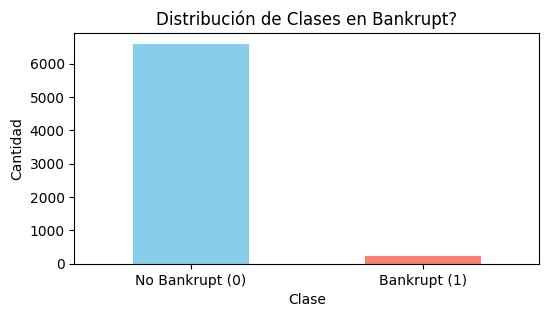

In [12]:
def plot_objetivo(bank_data):
    # Contar la cantidad de cada clase en la variable 'Bankrupt?'
    class_counts = bank_data.value_counts()

    # Crear el gráfico de barras
    plt.figure(figsize=(6, 3))
    class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Distribución de Clases en Bankrupt?')
    plt.xlabel('Clase')
    plt.ylabel('Cantidad')
    plt.xticks(ticks=[0, 1], labels=['No Bankrupt (0)', 'Bankrupt (1)'], rotation=0)
    plt.show()

    return
plot_objetivo(y)

# Train test split

Como se puede apreciar la clase de tipo 1 (Bankrupt) está desbalanceada, por lo tanto habrá que tenerlo en cuenta a la hora de dividir los datos y de entrenar el modelo.



Se dividen los datos escalados en conjuntos de entrenamiento y prueba.

`stratify=y`: Asegura que la división mantiene la misma proporción de clases en los conjuntos de entrenamiento y prueba, lo que es particularmente útil para problemas de clasificación.

In [13]:
# Función para establecer semillas
def set_seeds(seed=42):
    random.seed(seed)  # Establece la semilla para la biblioteca random
    np.random.seed(seed)  # Establece la semilla para la biblioteca numpy
    tf.random.set_seed(seed)  # Establece la semilla para TensorFlow
set_seeds(42)

In [46]:
# División en train y test
test_val = 0.1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_val, random_state=42, stratify=y)



Estandarizamos las variables para mejorar el rendimiento de la red neuronal. Esto se hace después del train_test_split para evitar data leakage

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [81]:
print(y_train.value_counts())
print(y_val.value_counts())

Bankrupt?
0    5279
1     176
Name: count, dtype: int64
Bankrupt?
0    660
1     22
Name: count, dtype: int64


Balaceo de clases usando undersampling

In [281]:
# Balanceo de clases mediante submuestreo de la clase mayoritaria
sampling_strategy = {0: 380, 1: 176}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

In [282]:
#Se comprueba que las claces estén balanceadas
print(y_train_res.value_counts())

Bankrupt?
0    380
1    176
Name: count, dtype: int64


In [283]:
train_features = X_train_res
val_features = X_val_scaled

train_labels = y_train_res
val_labels =  y_val

input_len = train_features.shape[1]

Definimos el modelo teniendo en cuenta que el problema es de clasificación entre dos clases.
Activación: sigmoid
Función de pérdida: binary_crossentropy
Métrica: accuracy

## Modelado

## Modelo #1 - Optimizador RMS

El primer modelo se define usando una capa de entrada con las dimensiones del conjunto de datos de entrenamiento y una activación normal.

Las capas intermedias se crean dinámicamente de acuerdo a los parámetros de entrada a la función.

Finalmente, la capa de salida se activa con una función sigmoide. Esto se hace porque la variable objetivo tiene dos clases [0,1]

In [284]:
def make_model(dense_layers=1, dense_dropout=0.0, dense_units=32, learning_rate=0.01, verbose=False):
  # Crear el modelo
  model = Sequential()

  # Capa de entrada
  model.add(Dense(units=dense_units,
                  input_dim=input_len,  # 'input_len' debería definirse antes de llamar a esta función
                  kernel_initializer='normal',
                  activation='relu'))
  model.add(Dropout(dense_dropout))

  # Capas densas adicionales
  for i in range(1, dense_layers):
      model.add(Dense(units=dense_units,
                      kernel_initializer='normal',
                      activation='relu'))
      model.add(Dropout(dense_dropout))

  # Capa de salida
  model.add(Dense(1, activation='sigmoid'))

  # Compilar el modelo
  optimizer = tf.keras.optimizers.RMSprop(learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  if verbose:
      print('Capas densas: ' + str(dense_layers))
      print('Tasa de aprendizaje: ' + str(learning_rate))
      print('Dropout en capas densas: ' + str(dense_dropout))
      print('Neuronas capas intermedias: ' + str(dense_units))
      #print(model.summary())

  return model

### Grid Search

El modelo se comienza decidiendo cuales son las funciones de activación que vamos a utilizar

Se realizará GridSearch en este orden: Capas > Neuronas > Dropout > Tasa de aprendizaje > Batch size > Regularización > Optimizer

Primer modelo, dos capas con pocas neuronas. Probaré con 32 neuronas, 16 neuronas  y 8 neuronas.

Ajusto el grid search para que muestre los resultados de modelos con 1, 2 y 3 capas, el modelo de 3 capas se descarta, hace demasiado sobreajuste.

El modelo de 16 neuronas parece ser el que mejor comportamiento tiene para modelos de 1 y 2 capas.

Se prueban dropouts para las estructuras de 1 y 2 capas con 16 neuronas. El dropout que mejor evita el sobreajuste es 0.25.

Continuamos evaluando parámetros al modelo actual: 1 capa, 16 neuronas, 0.25 dropout

Para ajustar la tasa de aprendizaje del optimizador RMS probamos con valores típicos: 0.0001, 0.001 , 0.01, 0.1. Parece haber un buen rendimiento para 0.001 y 0.0001, probamos valores intermedios para realizar un ajuste fino.

Se observa que una tasa de aprendizaje del 0.0008 arroja unos resultados bastante buenos, rápidamente arroja una precisión del 85% sobre los datos de validación.

El batch size que ofrece mayor rendimiento en los gráficos de accuracy es 128.


Por último se ha realizado una representación de lo que ocurre en la gráfica de precisión cuando se ajusta la tasa de aprendizaje demasiado alta. Se pùede observar que al elegir una tasa de aprendizaje no óptima el modelo va dando 'bandazos' en la gráfica de validación. Esto se debe a que cuando la tasa de aprendizaje es demasiado alta podemos pasarnos la solución 'optima' cada vez que ajustamos los parámetros, lo que origina estas variaciones en la precisión.


Proposed 2 models
Capas densas: 1
Tasa de aprendizaje: 0.1
Dropout en capas densas: 0.25
Neuronas capas intermedias: 16
batch_size :128


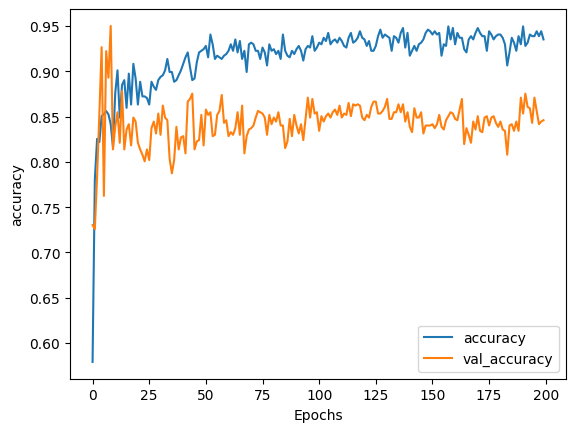

Capas densas: 1
Tasa de aprendizaje: 0.0008
Dropout en capas densas: 0.25
Neuronas capas intermedias: 16
batch_size :128


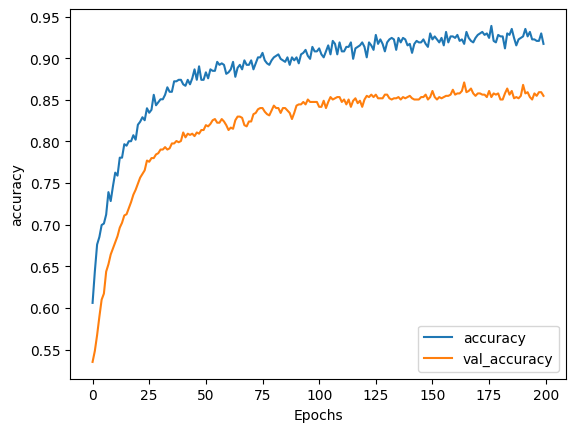

In [285]:
# Calcular los pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Definición de los hiperparámetros para la búsqueda en grid
batch_size = [128]
epochs = [200]
dense_layers = [1]
dense_dropout = [0.25]
learning_rate = [0.1, 0.0008]
dense_units = [16]

# Crear una lista de diccionarios con cada combinación posible de los hiperparámetros
param_grid = dict(dense_layers = dense_layers
                    , learning_rate = learning_rate
                    , batch_size = batch_size
                    , epochs = epochs
                    , dense_dropout = dense_dropout
                    , dense_units = dense_units
                 )

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

# Ciclo para entrenar cada combinación de hiperparámetros
for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dense_layers = param_grid[j].get("dense_layers")
    learning_rate = param_grid[j].get("learning_rate")
    batch_size = param_grid[j].get("batch_size")
    epochs = param_grid[j].get("epochs")
    dense_dropout = param_grid[j].get("dense_dropout")

    model = make_model(dense_layers = dense_layers
                   , learning_rate = learning_rate
                   , dense_dropout = dense_dropout
                   , dense_units = dense_units
                   , verbose = 1)

    print('batch_size :' + str(batch_size))
    history = model.fit(train_features,
                        train_labels,
                        batch_size = batch_size,
                        epochs = epochs,
                        class_weight=class_weights,
                        validation_data = (val_features, val_labels),
                        verbose = 0)

    plot_history_train(history, 'accuracy')
    accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy":accuracy})

results = pd.DataFrame(param_grid)

## Modelo #2 - optimizador ADAM y regularización L2

In [278]:
def make_model2(dense_layers = 1
               , dense_dropout = 0.0
               , dense_units=32
               , learning_rate = 0.01
               , verbose = False
               , l2_reg=0.002):

    # Crear el modelo
    model = Sequential()

    # Capa de entrada
    model.add(Dense(units=dense_units,
                    input_dim=input_len,
                    kernel_initializer='normal',
                    kernel_regularizer=l2(l2_reg),
                    activation='relu'))
    model.add(Dropout(dense_dropout))

    # Capas densas adicionales
    for i in range(1, dense_layers):
        model.add(Dense(units=dense_units,
                        kernel_initializer='normal',
                        kernel_regularizer=l2(l2_reg),
                        activation='relu'))
        model.add(Dropout(dense_dropout))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))


    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer = optimizer
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    if verbose:
        print('dense_layers :' + str(dense_layers))
        print('Learning rate :' + str(learning_rate))
        print('dense_dropout :' + str(dense_dropout))
        print('dense_units :' + str(dense_units))
        #print(model.summary())

    return model

### Grid Search

Seguiremos la misma secuencia para el grid search del modelo 2

Se realizará GridSearch en este orden: Capas > Neuronas > Dropout > Tasa de aprendizaje > Batch size > Regularización > Optimizer

Primer modelo, dos capas con pocas neuronas. Probaré con 32 neuronas, 16 neuronas  y 8 neuronas.

Ajusto el grid search para que muestre los resultados de modelos con 1, 2 y 3 capas, el modelo de 3 capas se descarta, hace demasiado sobreajuste.

El modelo de 16 neuronas parece ser el que mejor comportamiento tiene para modelos de 1 y 2 capas.

Se prueban dropouts para las estructuras de 1 y 2 capas con 16 neuronas. El dropout que mejor evita el sobreajuste es 0.25.

Continuamos evaluando parámetros al modelo actual: 1 capa, 16 neuronas, 0.25 dropout

Para ajustar la tasa de aprendizaje del optimizador RMS probamos con valores típicos: 0.0001, 0.001 , 0.01, 0.1. Parece haber un buen rendimiento para 0.001 y 0.0001, probamos valores intermedios para realizar un ajuste fino.

Se observa que una tasa de aprendizaje del 0.0008 arroja unos resultados bastante buenos, rápidamente arroja una precisión del 85% sobre los datos de validación.

El batch size que ofrece mayor rendimiento en los gráficos de accuracy es 256.



Proposed 1 models
dense_layers :1
Learning rate :0.0008
dense_dropout :0.25
dense_units :16
batch_size :256


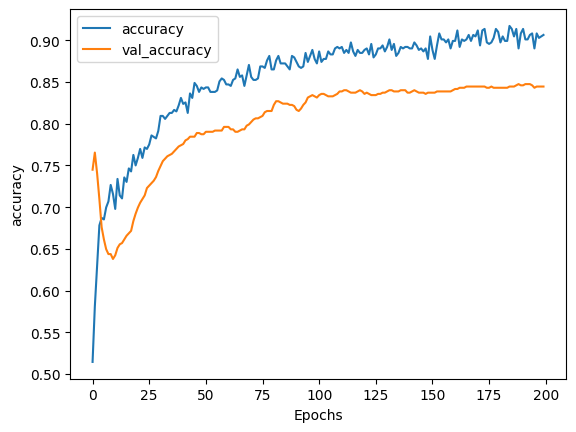

In [295]:
# Calcular los pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Definición de los hiperparámetros para la búsqueda en grid
batch_size = [256]
epochs = [200]
dense_layers = [1]
dense_dropout = [0.25]
learning_rate = [0.0008]
dense_units = [16]

import itertools
# Crear una lista de diccionarios con cada combinación posible de los hiperparámetros
param_grid = dict(dense_layers = dense_layers
                    , learning_rate = learning_rate
                    , batch_size = batch_size
                    , epochs = epochs
                    , dense_dropout = dense_dropout
                    , dense_units = dense_units
                 )

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

# Ciclo para entrenar cada combinación de hiperparámetros
for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dense_layers = param_grid[j].get("dense_layers")
    learning_rate = param_grid[j].get("learning_rate")
    batch_size = param_grid[j].get("batch_size")
    epochs = param_grid[j].get("epochs")
    dense_dropout = param_grid[j].get("dense_dropout")

    model2 = make_model2(dense_layers = dense_layers
                   , learning_rate = learning_rate
                   , dense_dropout = dense_dropout
                   , dense_units = dense_units
                   , verbose = 1)

    print('batch_size :' + str(batch_size))
    history = model2.fit(train_features,
                        train_labels,
                        batch_size = batch_size,
                        epochs = epochs,
                        class_weight=class_weights,
                        validation_data = (val_features, val_labels),
                        verbose = 0)

    plot_history_train(history, 'accuracy')
    accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy":accuracy})

results = pd.DataFrame(param_grid)

Comparar predicciones para ambos modelos

22/22 [==============================] - 0s 1ms/step
Confusion matrix

 [[563  97]
 [  2  20]]


<Axes: >

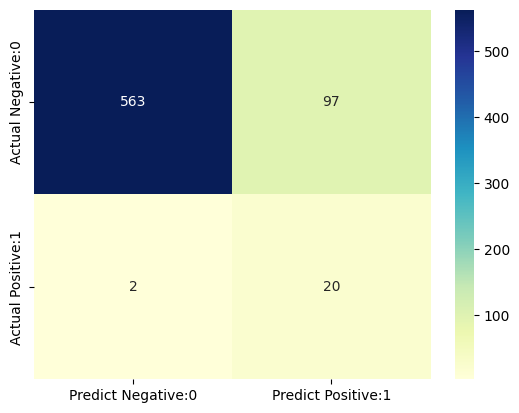

In [286]:
# Predicciones en el conjunto de prueba
y_pred = (model.predict(val_features) > 0.5).astype("int32")

# Muestra la matriz de confusión
cm = confusion_matrix(val_labels, y_pred)
print('Confusion matrix\n\n', cm)

# Visualización del mapa de calor de la matriz de confusión
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'],
                                 index=['Actual Negative:0', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

22/22 [==============================] - 0s 2ms/step
Confusion matrix

 [[557 103]
 [  3  19]]


<Axes: >

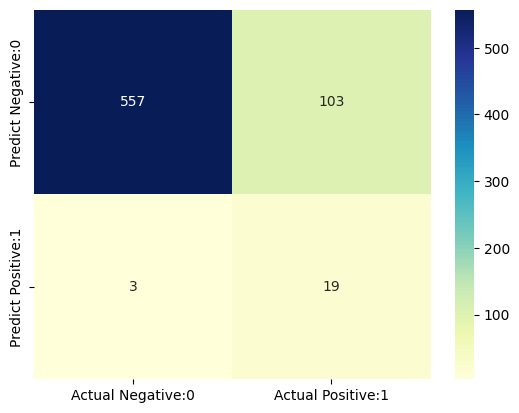

In [296]:
# Predicciones en el conjunto de prueba
y_pred = (model2.predict(val_features) > 0.5).astype("int32")

# Muestra la matriz de confusión
cm = confusion_matrix(val_labels, y_pred)
print('Confusion matrix\n\n', cm)

# Visualización del mapa de calor de la matriz de confusión
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Negative:0', 'Actual Positive:1'],
                                 index=['Predict Negative:0', 'Predict Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Mirando a las matrices de confusión obtenemos unos resultados bastante buenos, sobre todo teniendo en cuenta que el modelo predice correctamente la mayoría de verdaderos positivos (empresas en riesgo de quiebra), también arroja una notable cantidad de falsos positivos, aunque en la mayoría de casos de uso será más aceptable detectar estas empresas al borde de la quiebra que pasar por alto empresas quebradas.

## Modelo 2.1 (Haciendo feature engineering)

Ahora se va a intentar hacer feature engineering sobre el segundo modelo.

### Visualización de las distribuciones

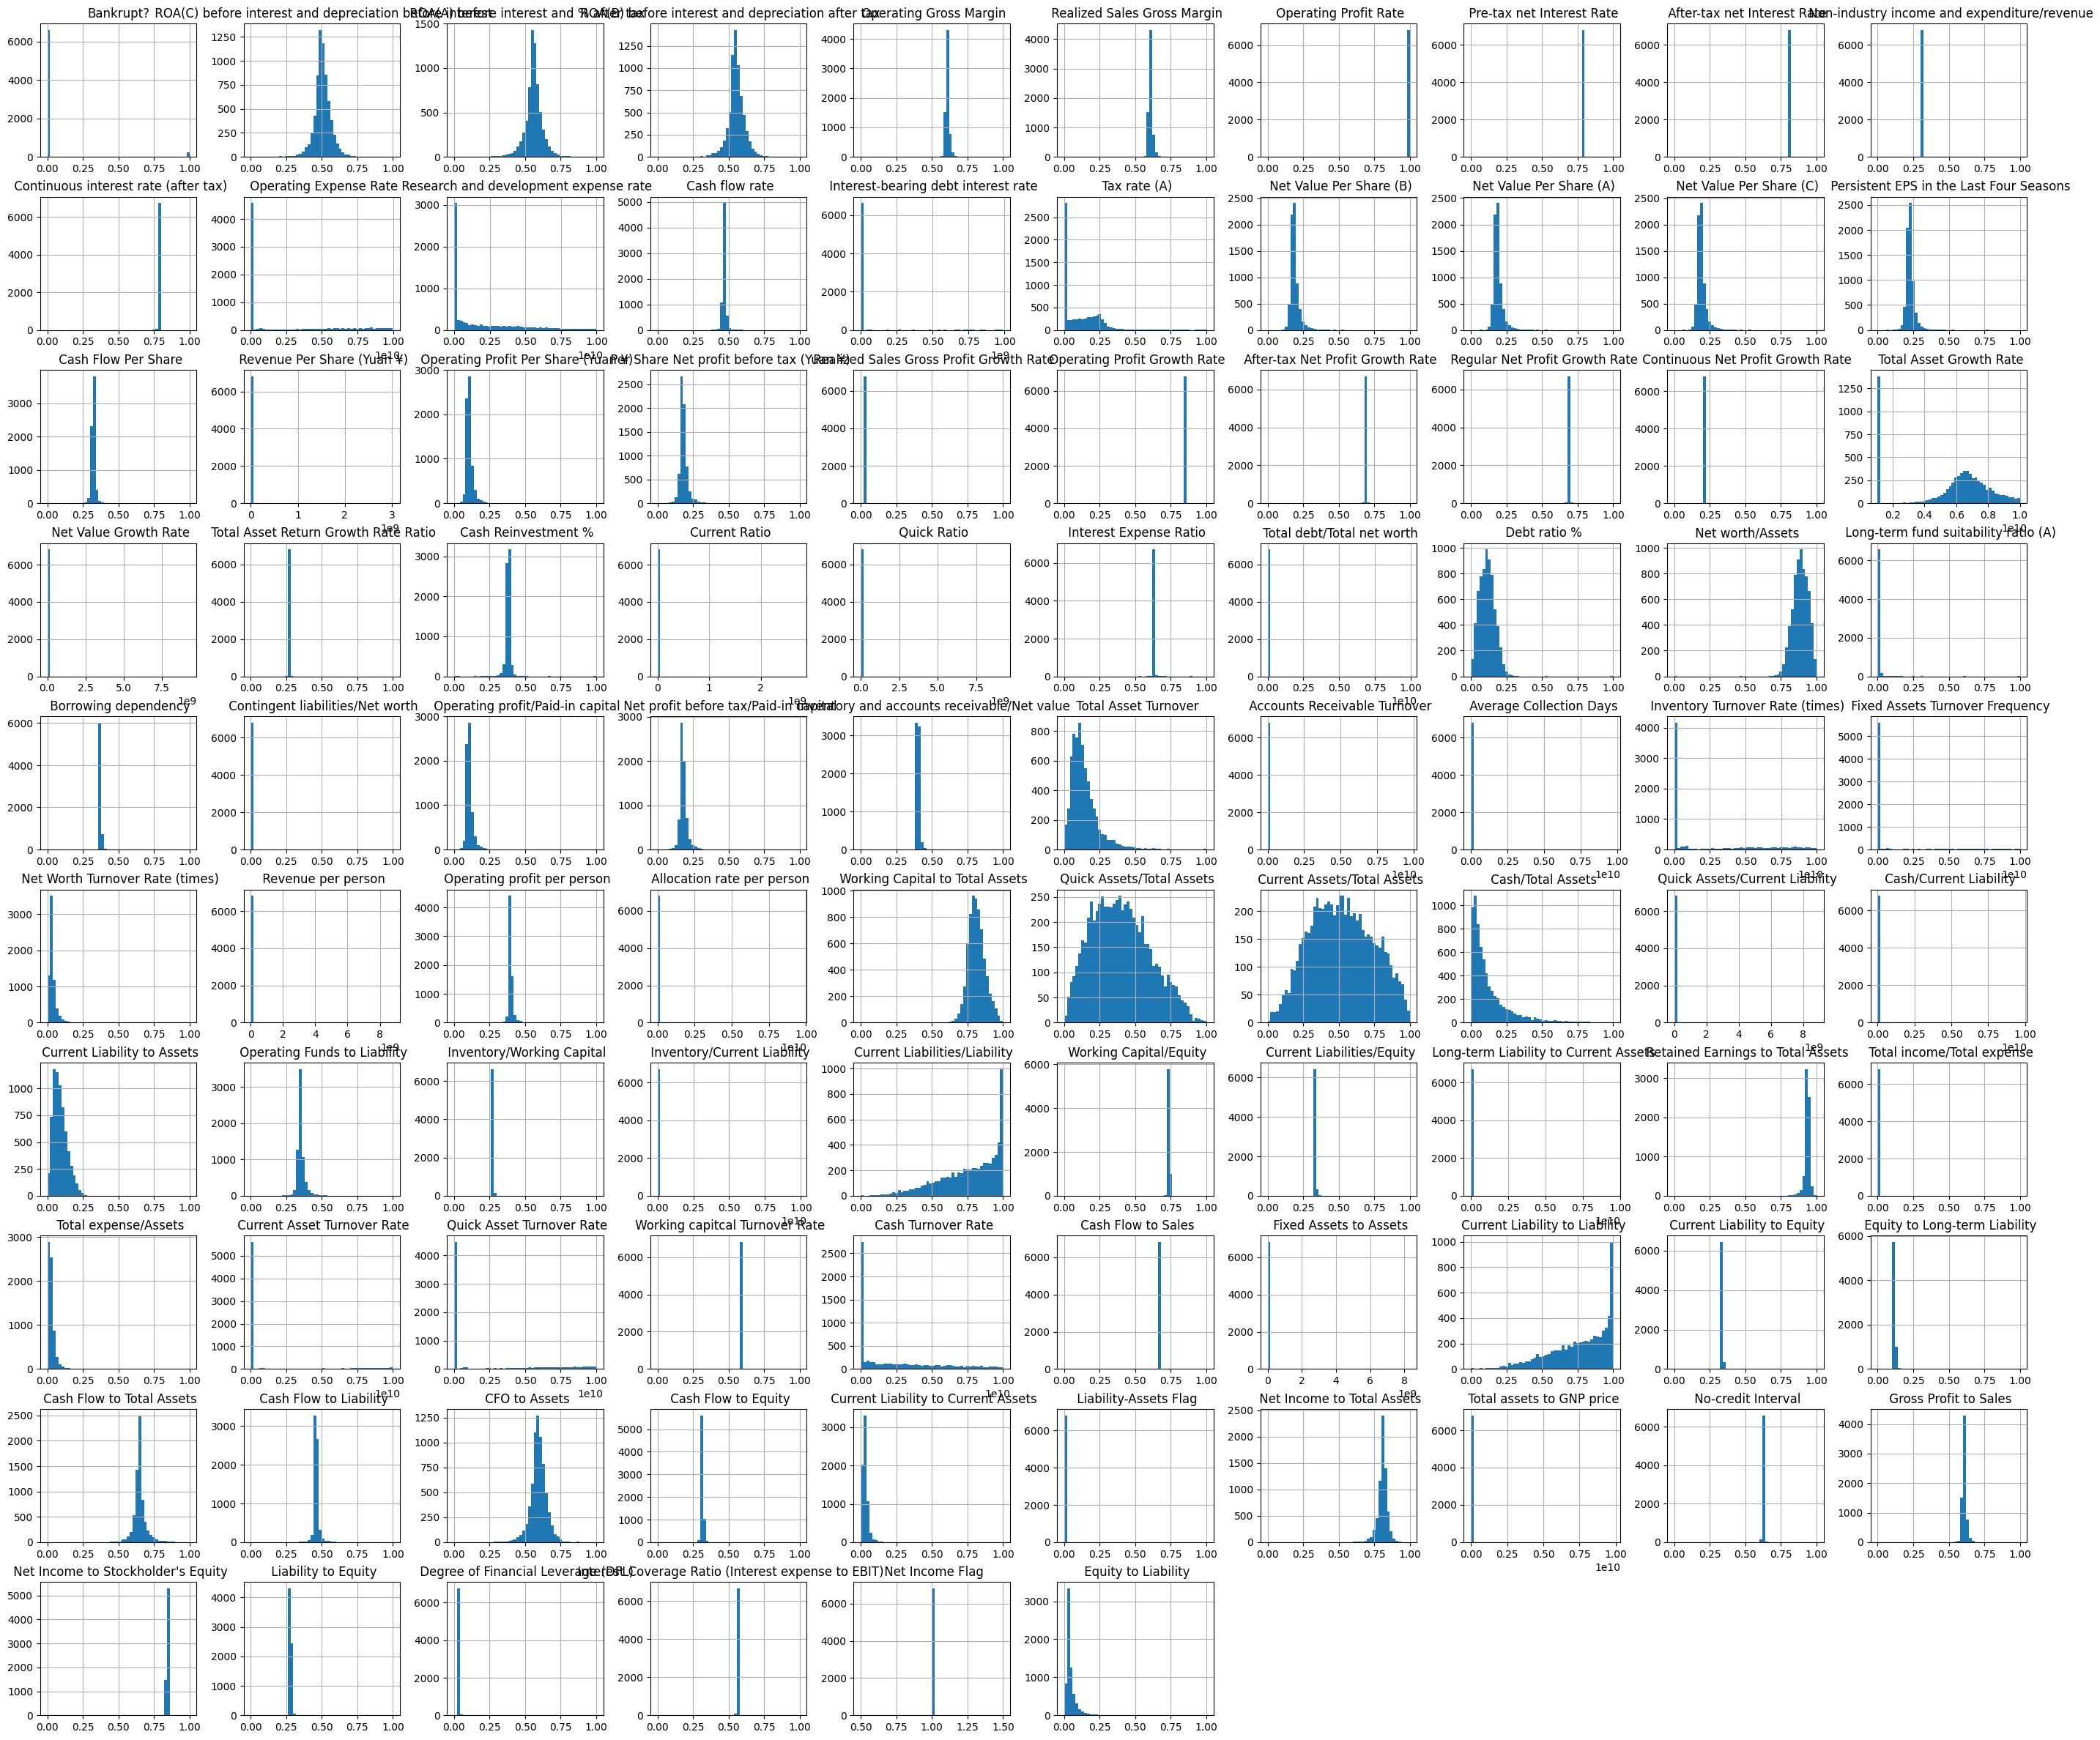

In [221]:
#Histogramas de las variables

bank_data.hist(figsize = (35,30), bins = 50)
plt.show()

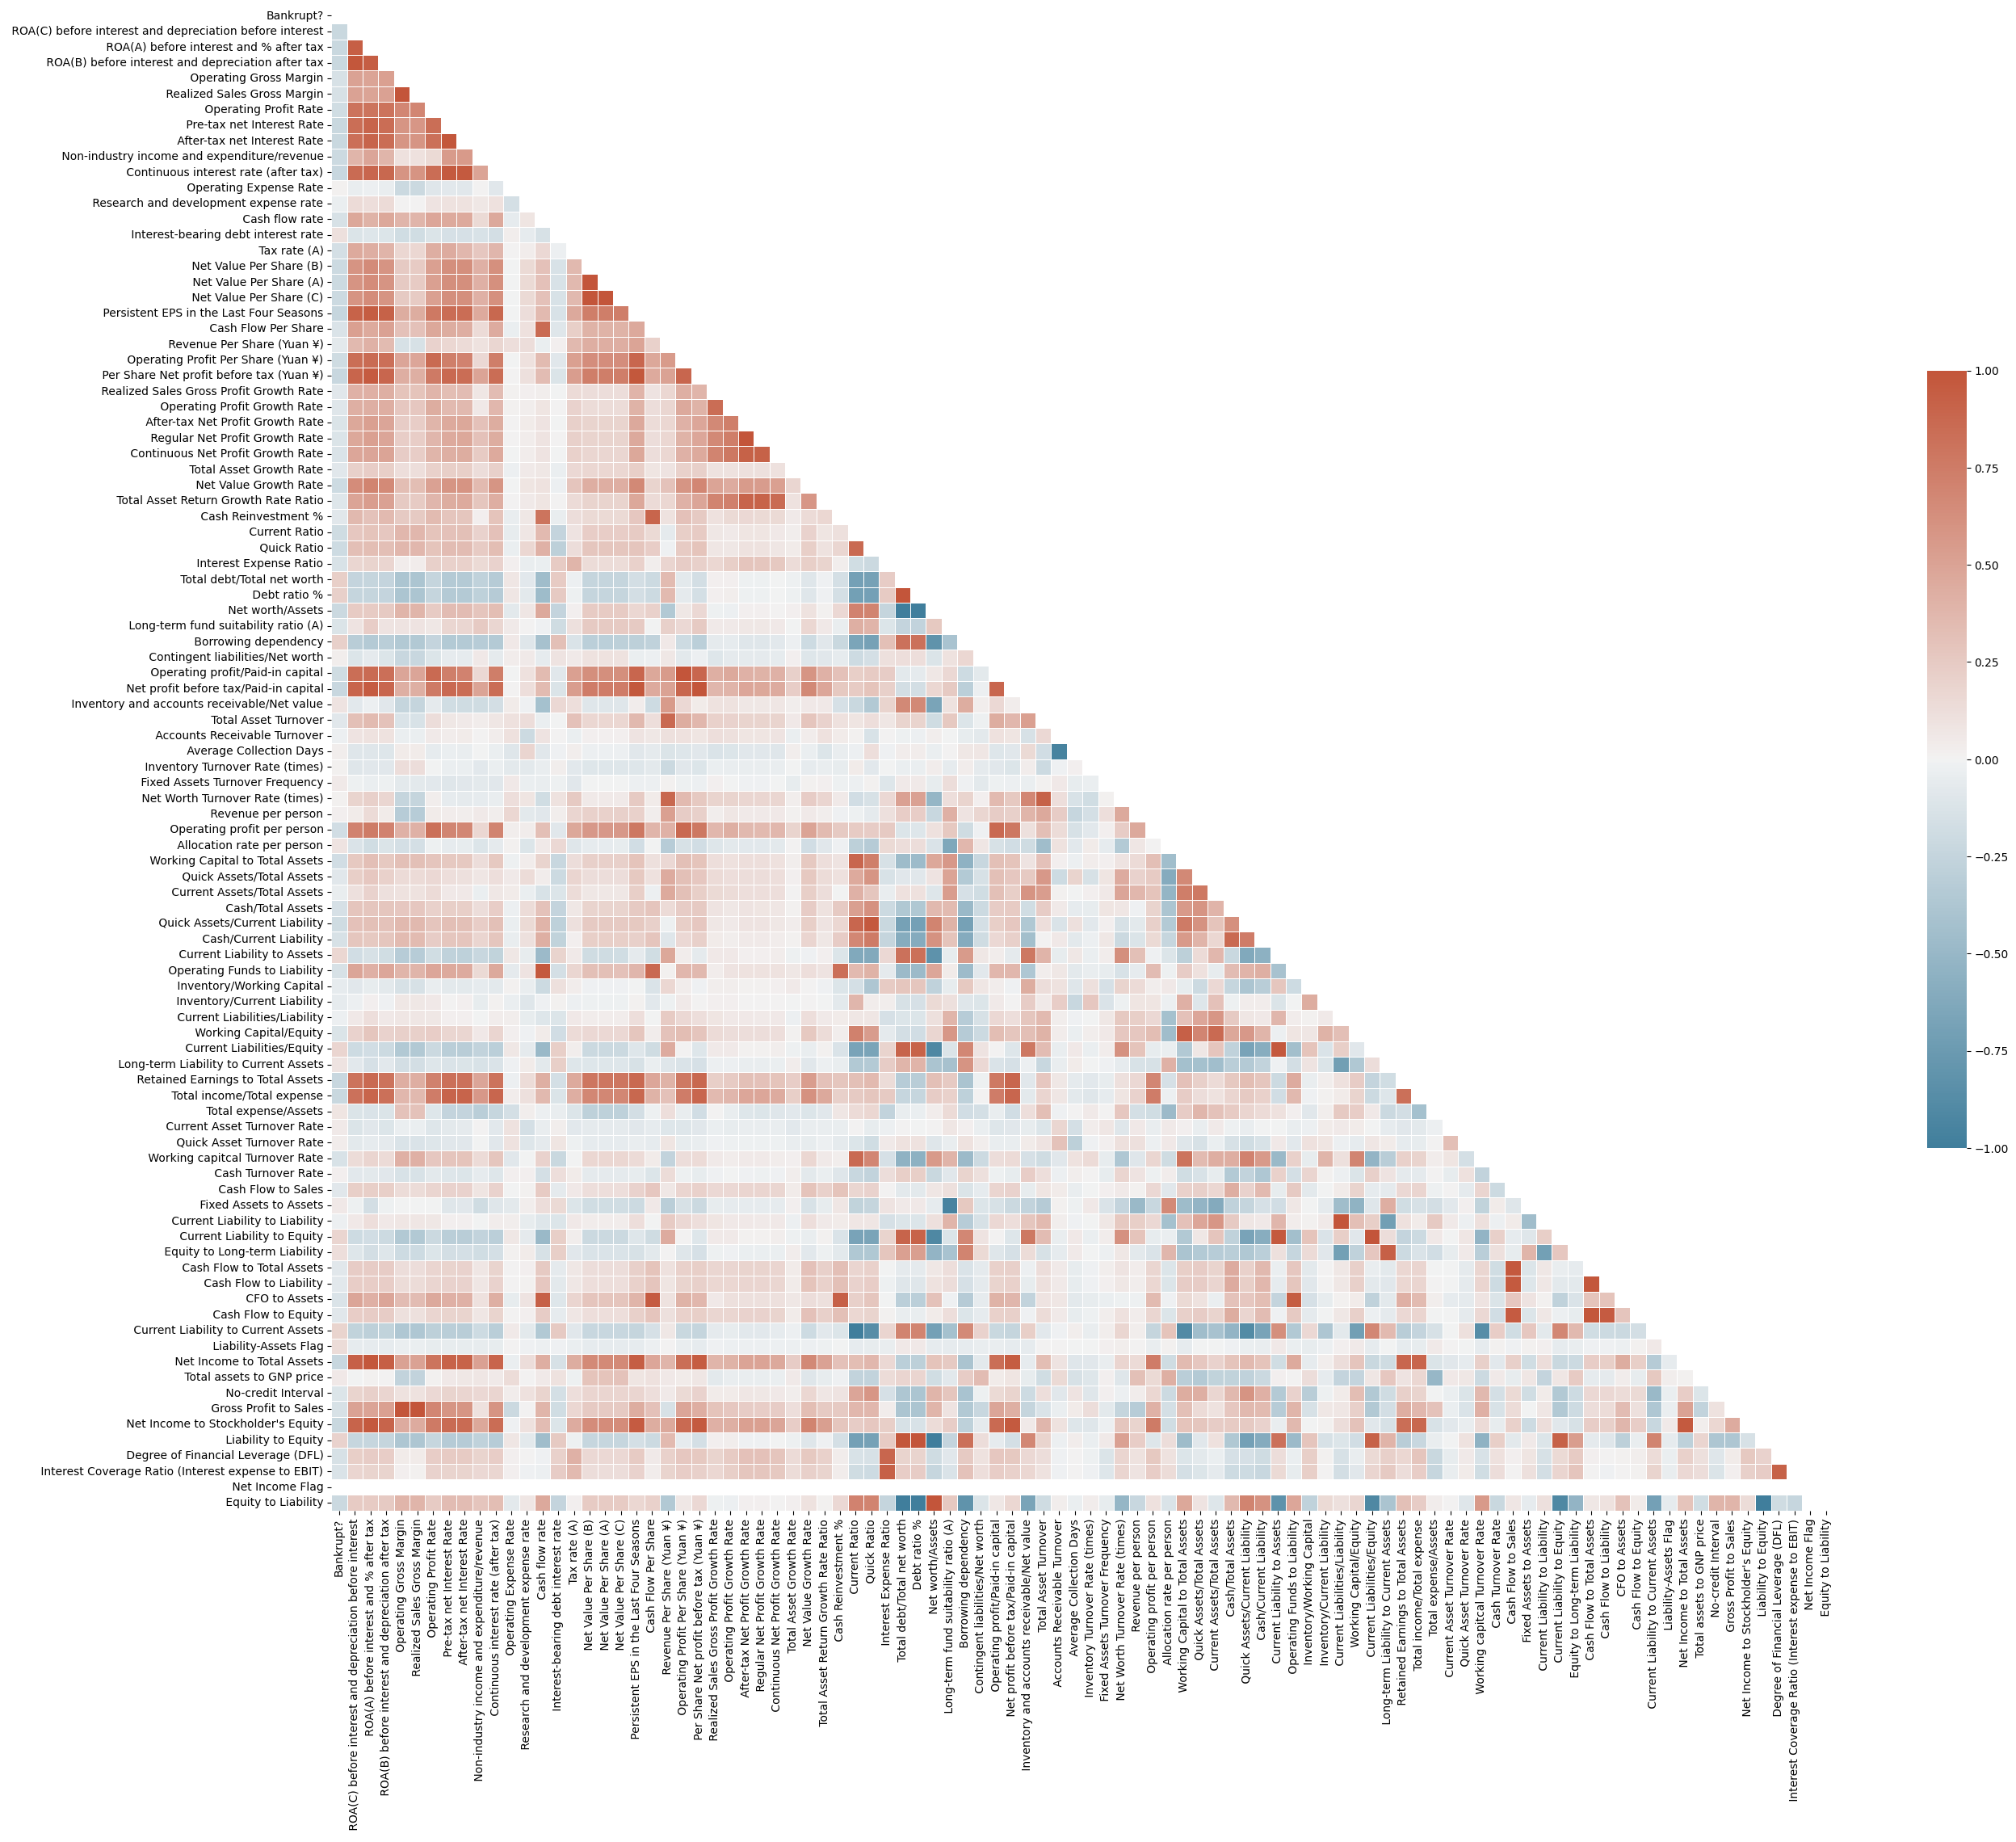

In [222]:
# Mapa de calor de las correlaciones (Spearman)

f, ax = plt.subplots(figsize=(30, 25))
mat = bank_data.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

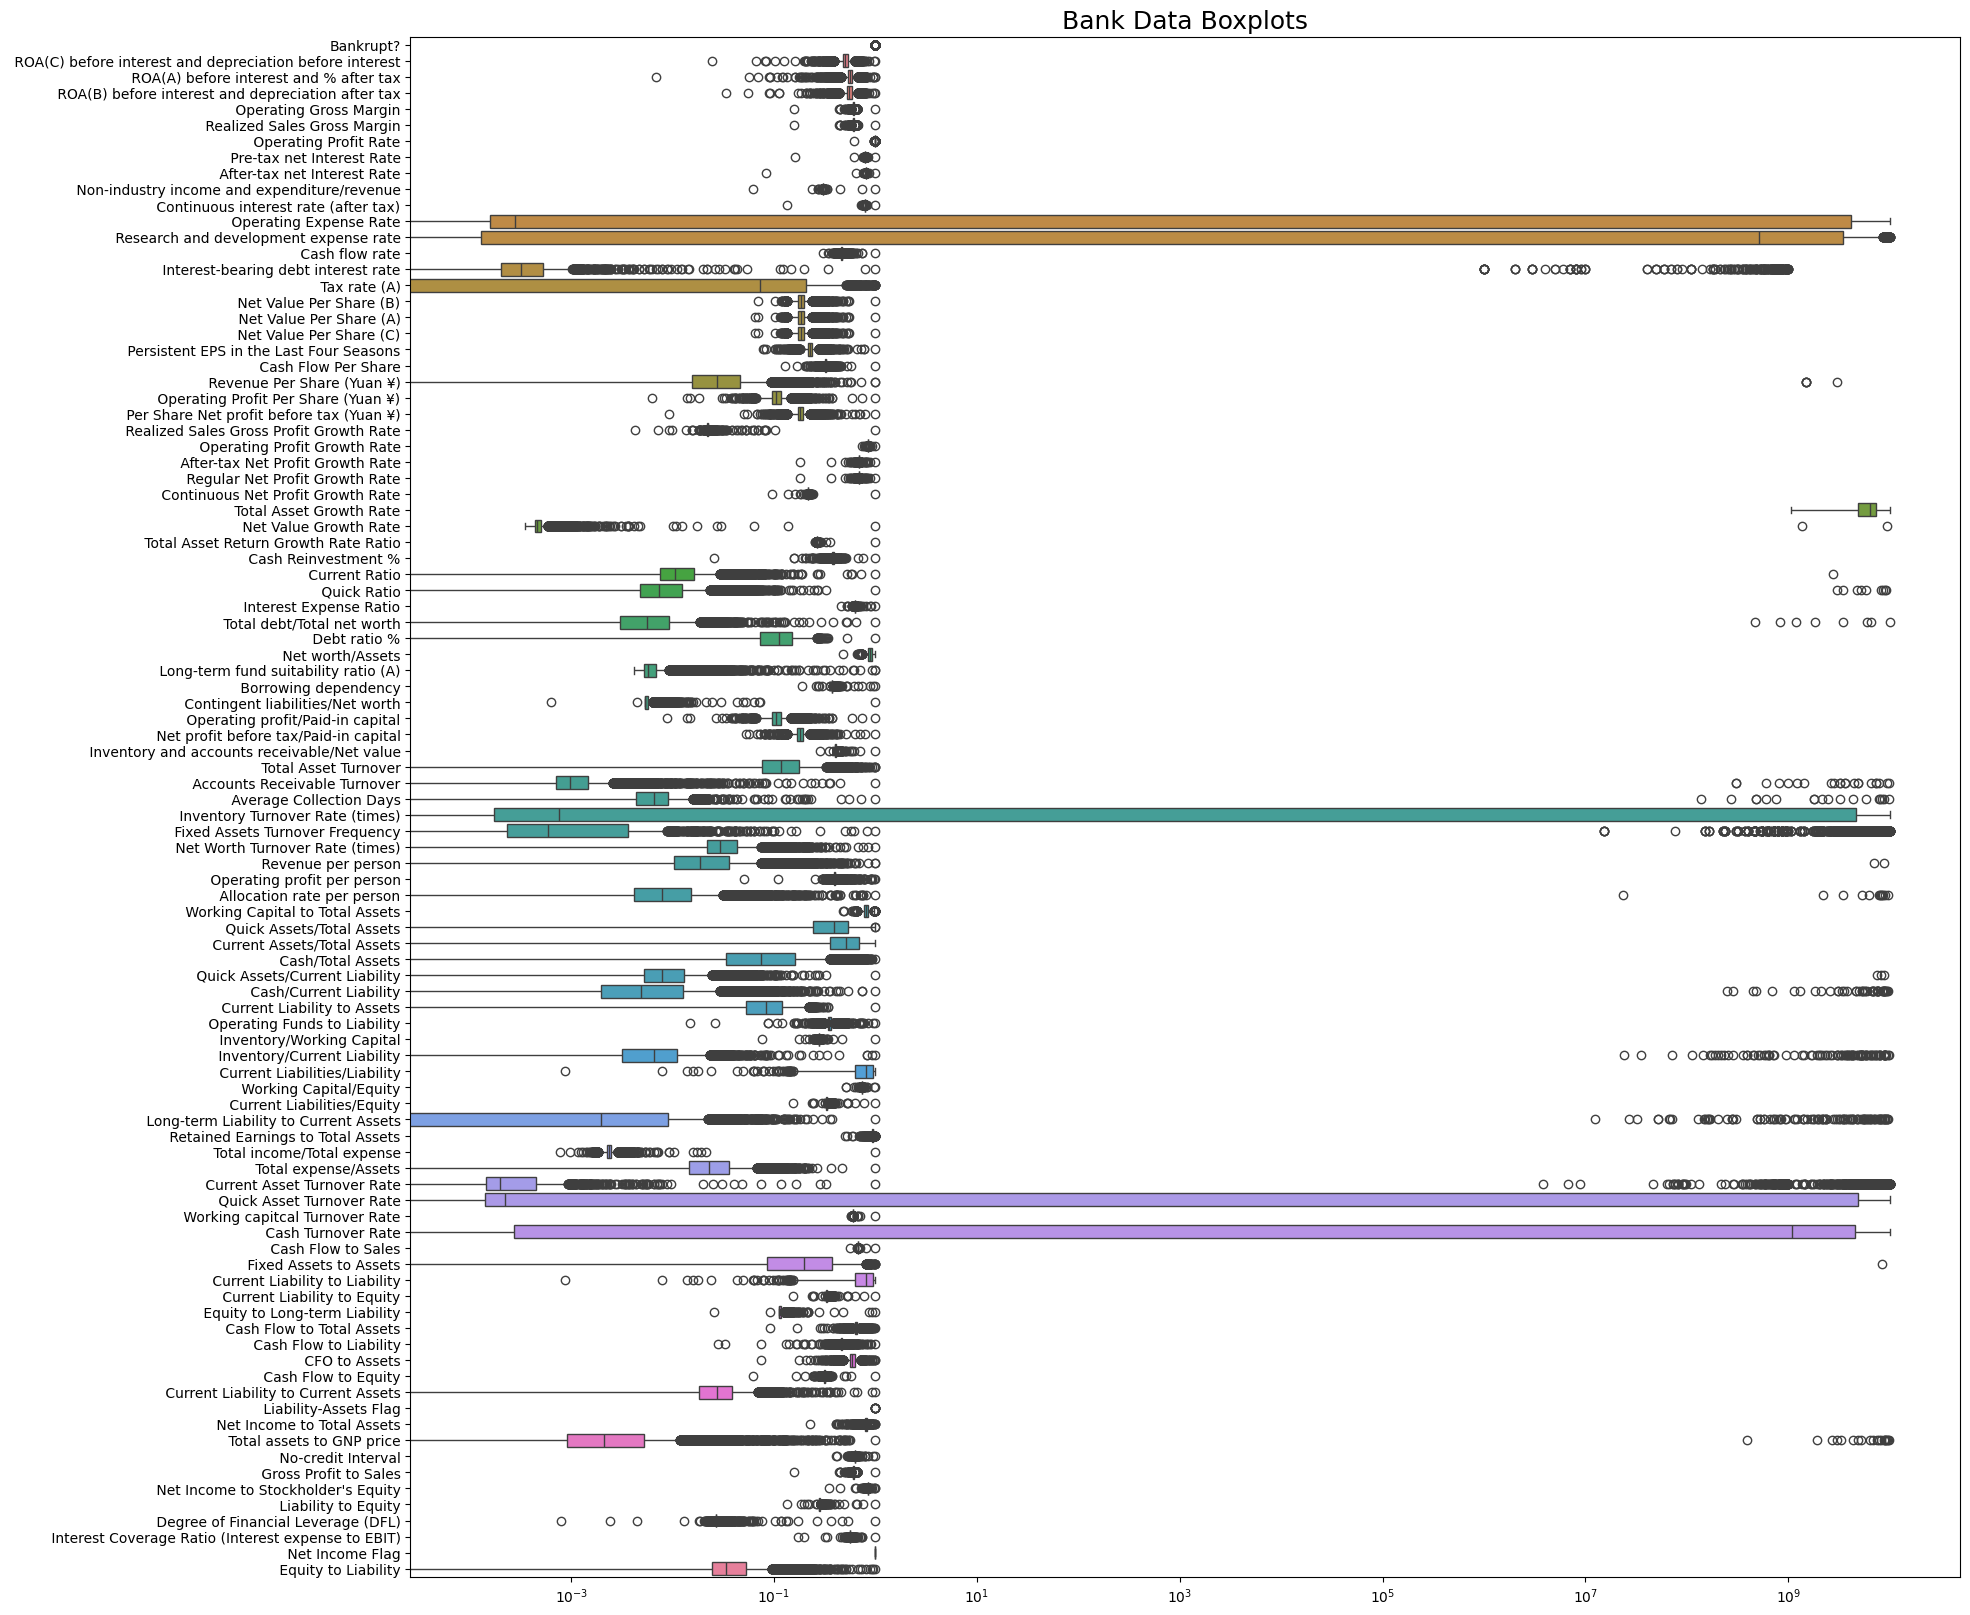

In [223]:
# BoxPlots

plt.figure(figsize = (20,20))
ax =sns.boxplot(data = bank_data, orient="h")
ax.set_title('Bank Data Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

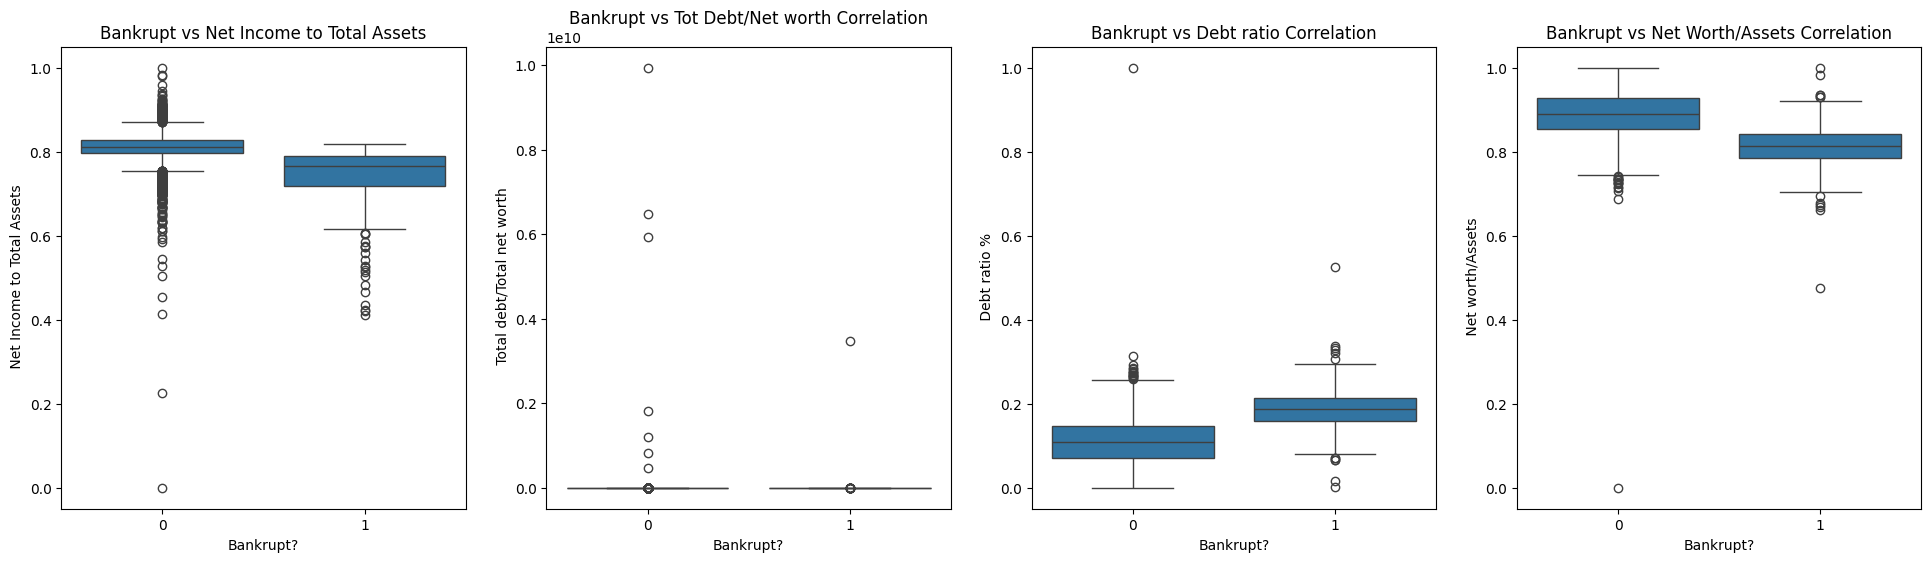

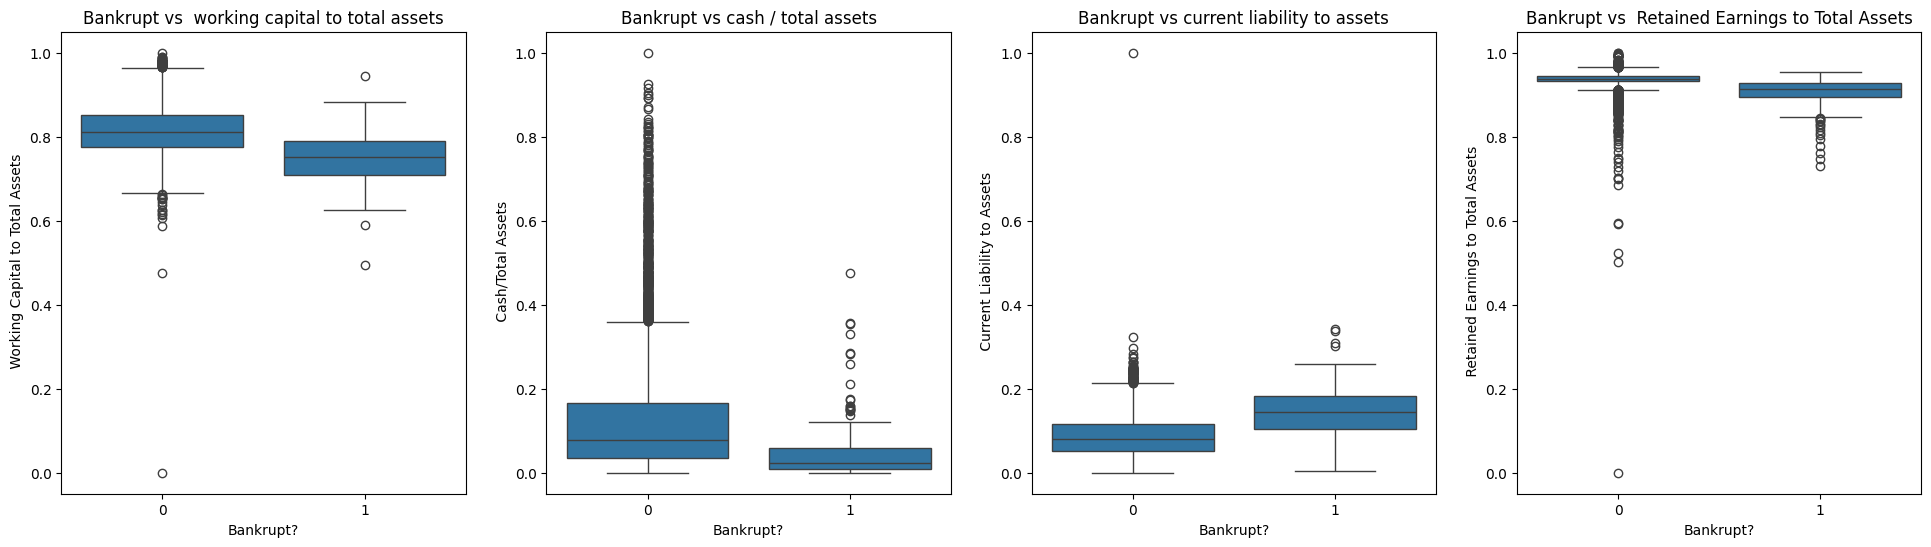

In [224]:
# Plotting interesting features
f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x=target, y=" Net Income to Total Assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs Net Income to Total Assets')

sns.boxplot(x=target, y=" Total debt/Total net worth", data=bank_data, ax=axes[1])
axes[1].set_title('Bankrupt vs Tot Debt/Net worth Correlation')


sns.boxplot(x=target, y=" Debt ratio %", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs Debt ratio Correlation')


sns.boxplot(x=target, y=" Net worth/Assets", data=bank_data, ax=axes[3])
axes[3].set_title('Bankrupt vs Net Worth/Assets Correlation')

plt.show()

# Plotting other interesting features

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x=target, y=" Working Capital to Total Assets", data=bank_data, ax=axes[0])
axes[0].set_title('Bankrupt vs  working capital to total assets')

sns.boxplot(x=target, y=" Cash/Total Assets", data=bank_data, ax=axes[1])
axes[1].set_title('Bankrupt vs cash / total assets')


sns.boxplot(x=target, y=" Current Liability to Assets", data=bank_data, ax=axes[2])
axes[2].set_title('Bankrupt vs current liability to assets')


sns.boxplot(x=target, y=" Retained Earnings to Total Assets", data=bank_data, ax=axes[3])
axes[3].set_title('Bankrupt vs  Retained Earnings to Total Assets')

plt.show()

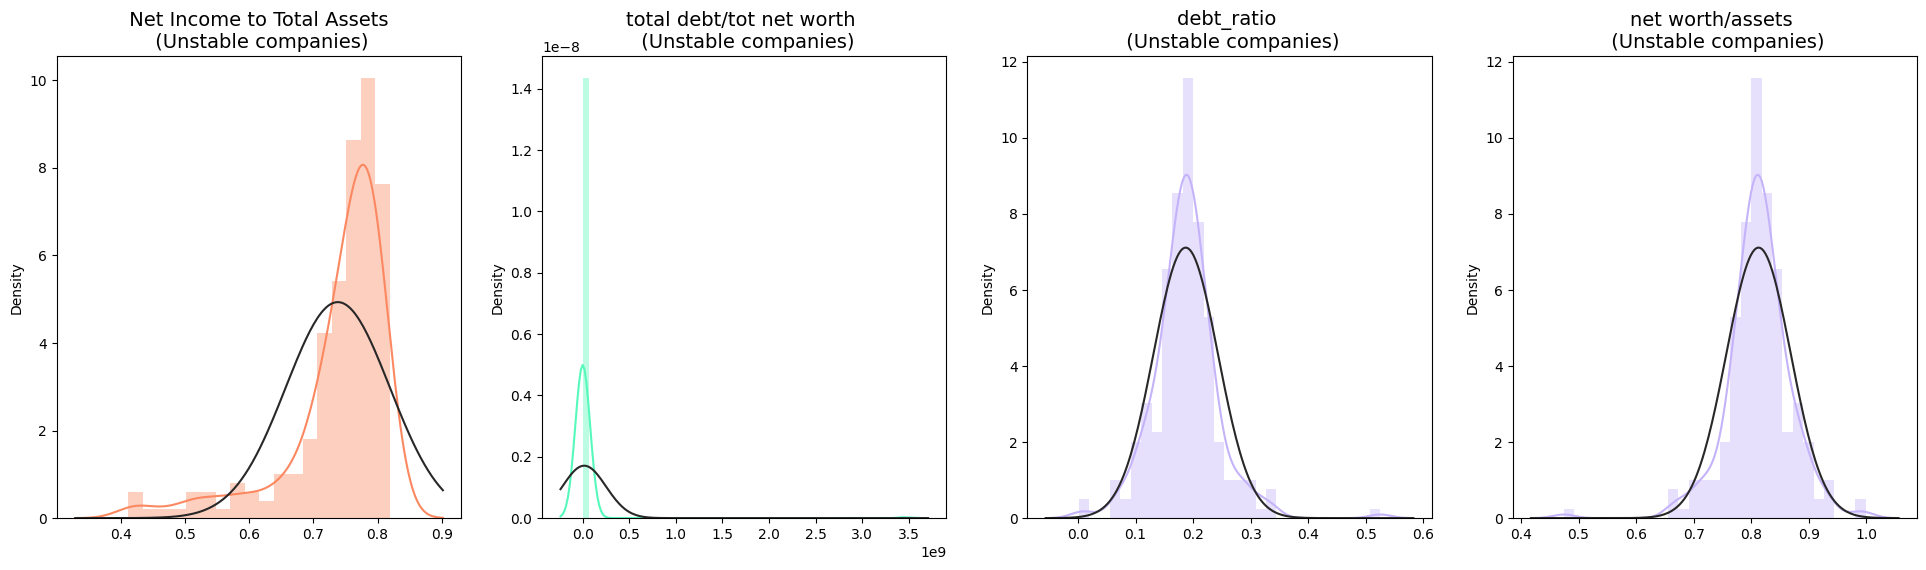

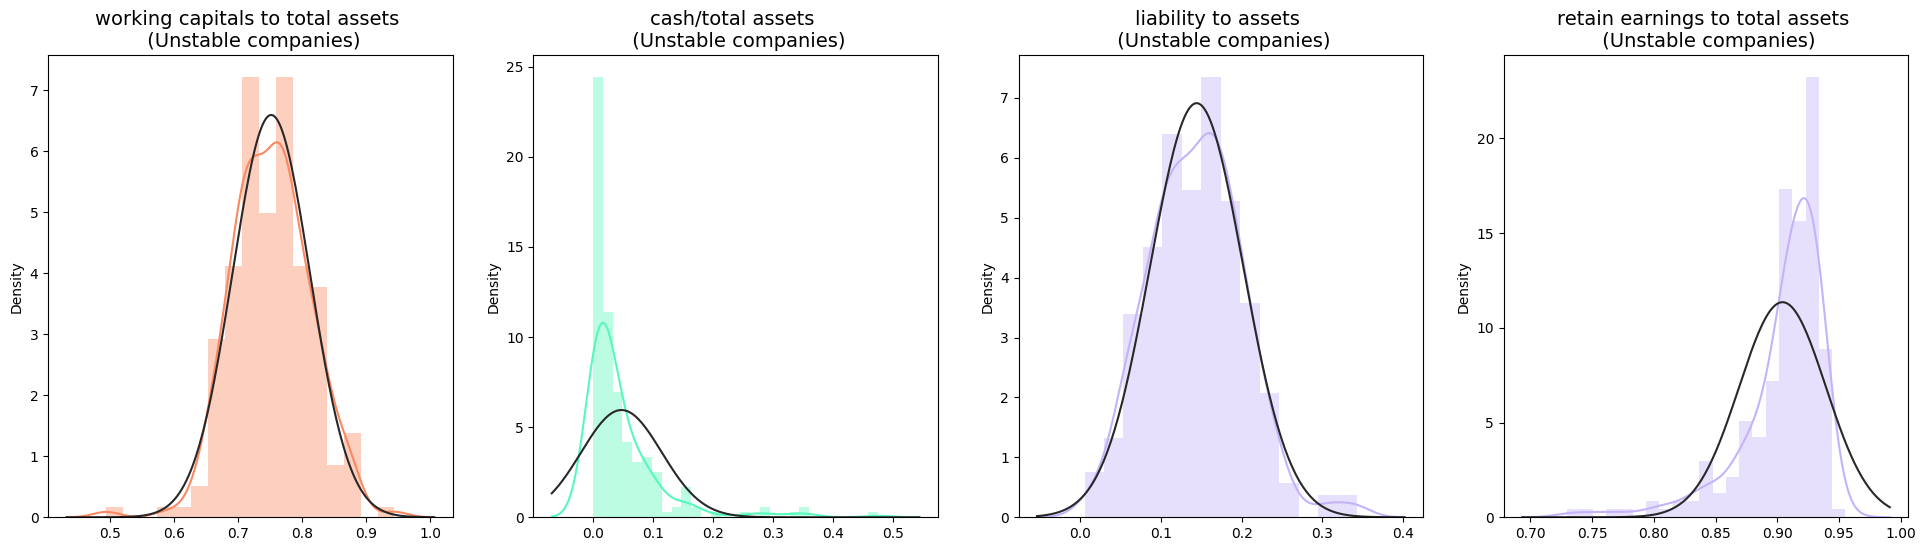

In [225]:
# Plotting the feature distributions for close to bankrputcy companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = bank_data[' Net Income to Total Assets'].loc[bank_data[target] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title(' Net Income to Total Assets \n (Unstable companies)', fontsize=14)

tot_debt_net = bank_data[' Total debt/Total net worth'].loc[bank_data[target] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = bank_data[' Debt ratio %'].loc[bank_data[target] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = bank_data[' Net worth/Assets'].loc[bank_data[target] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()


f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = bank_data[' Working Capital to Total Assets'].loc[bank_data[target] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = bank_data[' Cash/Total Assets'].loc[bank_data[target] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = bank_data[' Current Liability to Assets'].loc[bank_data[target] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = bank_data[' Retained Earnings to Total Assets'].loc[bank_data[target] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('retain earnings to total assets \n (Unstable companies)', fontsize=14)

plt.show()

### Tratar outliers

In [226]:
# Definir la función para asignar valores extremos a los outliers
def outliers_removal(feature, feature_name, dataset):
    # Identificar el 25º y 75º percentil
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    feat_iqr = q75 - q25

    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off

    # Asignar valores extremos a los outliers
    dataset[feature_name] = np.where(feature > feat_upper, feat_upper, feature)
    dataset[feature_name] = np.where(feature < feat_lower, feat_lower, feature)

    return dataset

# Aplicar la asignación de valores extremos a las columnas cuyo valor promedio sea >1 o <0
for col in bank_data.columns:
    if bank_data[col].mean() > 1 or bank_data[col].mean() < 0:
        new_df = outliers_removal(bank_data[col], col, bank_data)

In [227]:
new_df = bank_data.copy()

In [228]:
new_df.shape

(6819, 96)

### Tratamiento de asimetría

In [229]:
# Definir la función para aplicar la transformación logarítmica
def log_trans(data):
    for col in data.columns:
        if data[col].mean() > 1 or data[col].mean() < 0:
            skew = data[col].skew()
            if skew > 0.5 or skew < -0.5:
                data[col] = np.log1p(data[col])
    return data

# Crear una copia del DataFrame excluyendo la columna 'Bankrupt?'
data_exclude_bankrupt = new_df.drop(columns=[target])

# Aplicar la función a las columnas restantes
data_norm = log_trans(data_exclude_bankrupt)

# Volver a añadir la columna 'Bankrupt?' al DataFrame transformado
data_norm[target] = new_df[target]



In [230]:
data_norm.shape

(6819, 96)

In [231]:
data_norm = new_df.copy()

In [232]:
print(data_norm[target].value_counts())

Bankrupt?
0    6599
1     220
Name: count, dtype: int64


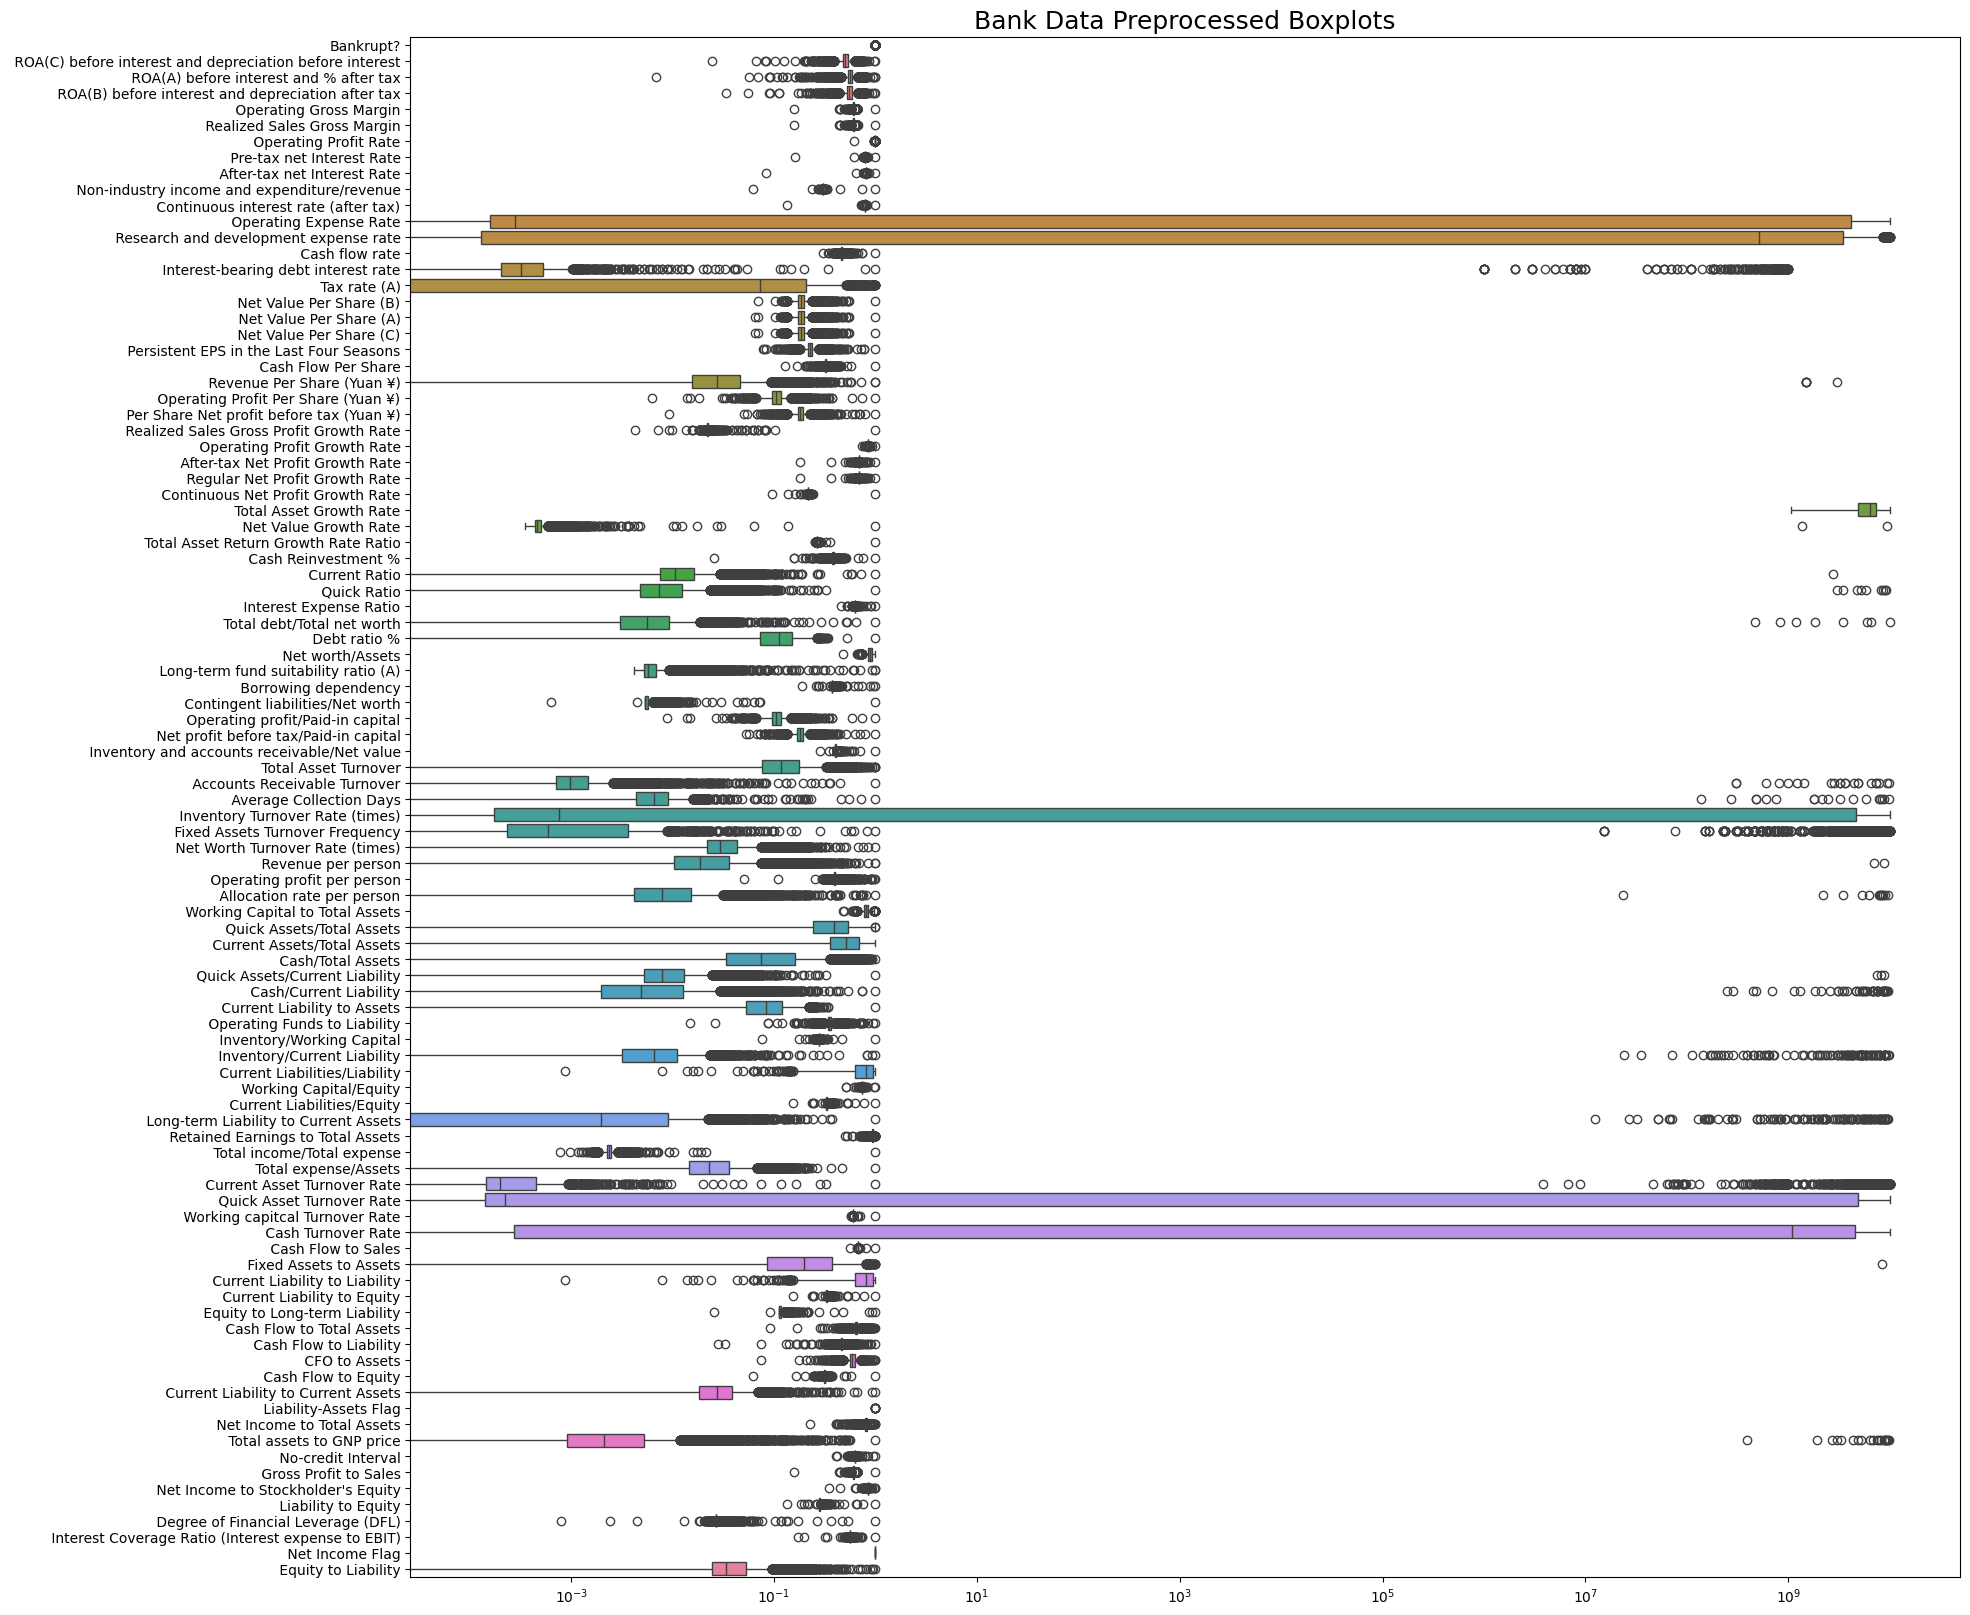

In [233]:
# Plotting Boxplots of the preprocessed numerical features

plt.figure(figsize = (20,20))
ax =sns.boxplot(data = data_norm, orient="h")
ax.set_title('Bank Data Preprocessed Boxplots', fontsize = 18)
ax.set(xscale="log")
plt.show()

In [234]:
# Separar características y etiqueta
X = data_norm.drop(columns=[target])
y = data_norm[target]


# División en train y test
test_val = 0.1
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_val, random_state=42, stratify=y)



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(y_train.value_counts())
print(y_val.value_counts())

Bankrupt?
0    5939
1     198
Name: count, dtype: int64
Bankrupt?
0    660
1     22
Name: count, dtype: int64


In [297]:
# Balanceo de clases mediante submuestreo de la clase mayoritaria
sampling_strategy = {0: 380, 1: 176}


rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)

print(y_train_res.value_counts())

train_features = X_train_res
val_features = X_val_scaled
#test_features = X_test_scaled

train_labels = y_train_res
val_labels =  y_val
#test_labels = y_test


input_len = train_features.shape[1]

Bankrupt?
0    380
1    176
Name: count, dtype: int64


### Modelo 3 - Usando la arquitectura del modelo #2

In [298]:
# define the model as much dynamic as possible to perform the grid search
def make_model3(dense_layers = 1
               , dense_dropout = 0.0
               , dense_units=32
               , learning_rate = 0.01
               , verbose = False
               , l2_reg=0.002):

    # create model
    model = Sequential()

    # Input layer
    model.add(Dense(units=dense_units,
                    input_dim=input_len,
                    kernel_initializer='normal',
                    kernel_regularizer=l2(l2_reg),
                    activation='relu'))
    model.add(Dropout(dense_dropout))

    # Additional dense layers
    for i in range(1, dense_layers):
        model.add(Dense(units=dense_units,
                        kernel_initializer='normal',
                        kernel_regularizer=l2(l2_reg),
                        activation='relu'))
        model.add(Dropout(dense_dropout))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))


    # Compile model

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer = optimizer
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])
    if verbose:
        print('dense_layers :' + str(dense_layers))
        print('Learning rate :' + str(learning_rate))
        print('dense_dropout :' + str(dense_dropout))
        print('dense_units :' + str(dense_units))
        #print(model.summary())

    return model

Proposed 1 models
dense_layers :1
Learning rate :0.0008
dense_dropout :0.3
dense_units :16
batch_size :64


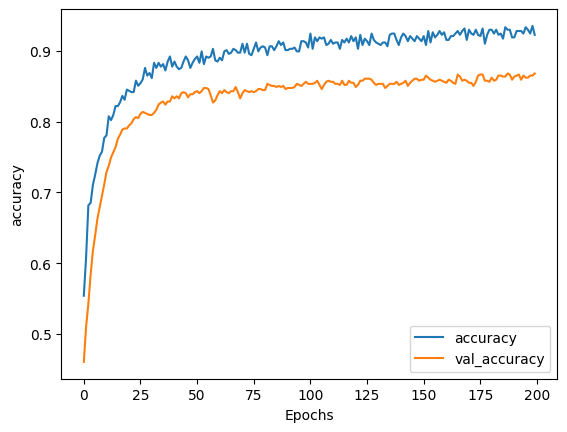

In [319]:
# Calcular los pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

batch_size = [64]
epochs = [200]
dense_layers = [1]
dense_dropout = [0.25]
learning_rate = [0.0008]
dense_units = [16]

# make a list of dictionaries containing every possible
# combination in the grid as a (smaller) dictionary
import itertools

param_grid = dict(dense_layers = dense_layers
                    , learning_rate = learning_rate
                    , batch_size = batch_size
                    , epochs = epochs
                    , dense_dropout = dense_dropout
                    , dense_units = dense_units
                 )

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dense_layers = param_grid[j].get("dense_layers")
    learning_rate = param_grid[j].get("learning_rate")
    batch_size = param_grid[j].get("batch_size")
    epochs = param_grid[j].get("epochs")
    dense_dropout = param_grid[j].get("dense_dropout")

    model3 = make_model3(dense_layers = dense_layers
                   , learning_rate = learning_rate
                   , dense_dropout = dense_dropout
                   , dense_units = dense_units
                   , verbose = 1)

    print('batch_size :' + str(batch_size))
    history = model3.fit(train_features,
                        train_labels,
                        batch_size = batch_size,
                        epochs = epochs,
                        class_weight=class_weights,
                        validation_data = (val_features, val_labels),
                        verbose = 0)

    plot_history_train(history, 'accuracy')
    accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"val_accuracy":accuracy})

results = pd.DataFrame(param_grid)

22/22 [==============================] - 0s 2ms/step
Confusion matrix

 [[574  86]
 [  4  18]]


<Axes: >

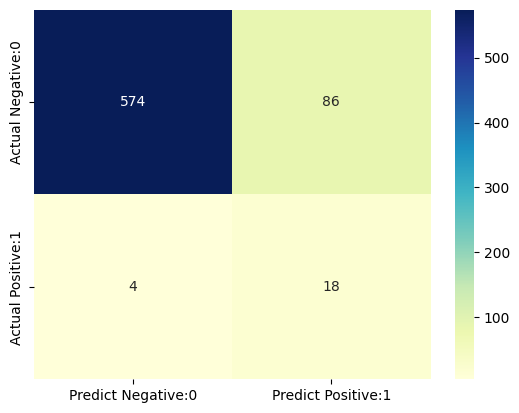

In [320]:
# Predicciones en el conjunto de prueba
y_pred = (model3.predict(val_features) > 0.5).astype("int32")

# Muestra la matriz de confusión
cm = confusion_matrix(val_labels, y_pred)
print('Confusion matrix\n\n', cm)

# Visualización del mapa de calor de la matriz de confusión
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'],
                                 index=['Actual Negative:0', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Si lo comparamos con el primer modelo, ha habido una mejora de rendimiento, sobre todo al predecir la clase mayoritaria.